# 项目：未前往就诊的挂号预约（Kaggle 的原始数据）

### 目录：
* 简介
* 数据整理
* 探索性数据分析
* 结论

### 简介

本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值。

* PatientId 病人ID (猜测类似于医院就诊号之类，一个PatientId可以对应多条记录）
* AppointmentID 预约ID(唯一）
* Gender 性别
* ScheduledDay 预约日期
* AppointmentDay 就诊日期
* Age 年龄
* Neighbourhood 街区
* Scholarship 福利保障
* Hypertension 高血压
* Diabetes 糖尿病
* Alcoholism 酗酒
* Handcap 伤残情况
* SMS_received 是否接收到信息提醒
* No-show  “No”表示病人已如约就诊，“Yes”说明病人未前往就诊

In [1]:
#导入数据集
# -*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

In [2]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
df.duplicated().sum()

0

没有发现缺失值和重复，但是有一些数据类型有问题，例如PatientId应该改成int，ScheduledDay和AppointmentDay应该是日期格式

In [6]:
df['PatientId'] = df['PatientId'].astype(int)

In [7]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [8]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [9]:
#检查是否修改成功
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [11]:
#这里有一处书写错误，Hipertension应该是Hypertension
df = df.rename(columns = {'Hipertension':'Hypertension'})

In [12]:
(df['ScheduledDay'].dt.date == df['AppointmentDay'].dt.date).mean()

0.34890117346892613

预约和就诊时间是同一天的记录占所有记录的35%左右，猜测患者是否爽约可能和这个时间有一定的相关性，稍后分析

In [13]:
#把‘No-show’由分类变量变成数值，0表示没就诊，1表示就诊
df[['show','No-show']] = pd.get_dummies(df['No-show'])

In [14]:
df = df.drop('No-show',axis=1)

In [15]:
#新建列‘wating_day’，值为0表示预约当天就诊
df['waiting_day'] = list(map(lambda x: x.days, df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date))

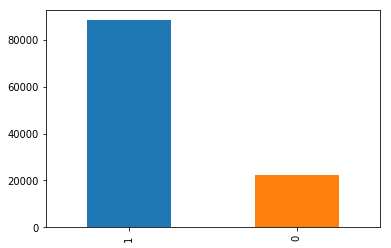

In [16]:
df['show'].value_counts().plot(kind='bar')

In [17]:
print(df.groupby(['show']).size())
show = df.groupby(['show']).size()[1]
noshow = df.groupby(['show']).size()[0]
showPercent = show /(noshow + show)
print("The percent of who showed up : {}% ".format(float("%.2f" % (showPercent*100))))
print("The percent of who did not showed up : {}% ".format("%.2f" % ((1-showPercent)*100)))

show
0    22319
1    88208
dtype: int64
The percent of who showed up : 79.81% 
The percent of who did not showed up : 20.19% 


In [18]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179.000000


# Age

In [19]:
df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,1,0


In [20]:
df[df['PatientId']==465943158731293]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,1,0


Age小于0的情况有一条记录，年龄不可能小于0,当作填写错误

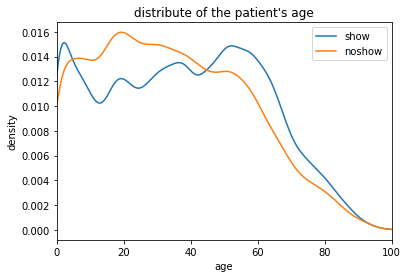

In [21]:
#密度图呈现不同年龄的守约和爽约分布情况
fig = plt.figure()
fig.set(alpha=0.2)

df.Age[df.show == 1].plot(kind='kde')   
df.Age[df.show == 0].plot(kind='kde')
plt.xlim(0,100) 
plt.xlabel(u"age")
plt.ylabel(u"density") 
plt.title(u"distribute of the patient's age")
plt.legend((u'show', u'noshow'),loc='best')

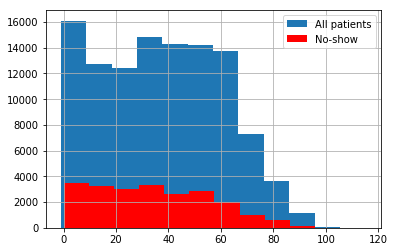

<Figure size 432x288 with 0 Axes>

In [22]:
df_age = df[df['Age']>=0]
ax = pd.Series(df['Age']).hist(bins=12)
pd.Series(df[['Age','show']][df['show']==0]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
ax.xlabel='Age'
plt.figure()
plt.show()

In [23]:
#对年龄进行分段处理
age_labels = ['0~10','10~20','20~30','30~40','40~50','50~60','60~70','70+']
age_cut = [-1,10,20,30,40,50,60,70,999]
df['phase'] = pd.cut(df['Age'], age_cut, labels=age_labels)

In [24]:
df['phase'].value_counts()

0~10     18749
50~60    15661
30~40    15052
40~50    14420
20~30    13783
10~20    13099
60~70    11189
70+       8573
Name: phase, dtype: int64

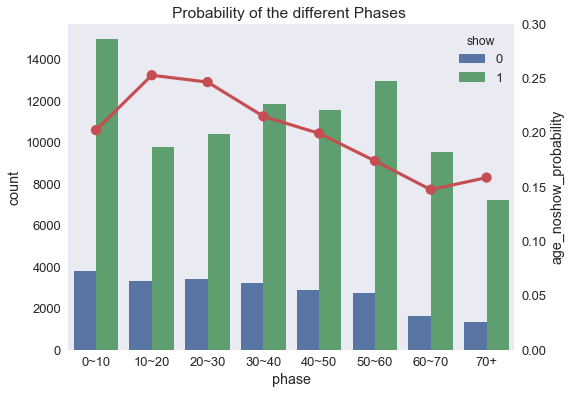

In [25]:
age_noshow_probability = df.query('show == 0')['phase'].value_counts(sort=False)/df['phase'].value_counts(sort=False)
age_noshow_probability.name = 'age_noshow_probability'

#设置背景参数、图片参数
plt.figure(figsize=(8,6))
sns.set(style='dark', color_codes=True, font_scale=1.3)

ax1 = sns.countplot(x='phase', data=df, hue='show')
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.3])
sns.pointplot(x=age_noshow_probability.index, y=age_noshow_probability, color='r', ax=ax2)
plt.title('Probability of the different Phases ');

在年龄段为‘10～20’岁阶段的爽约率最高，然后呈现逐渐递减的趋势，在70+的时候稍有提升。

# Gender

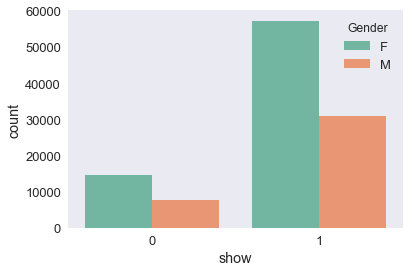

In [26]:
#在不同性别的情况下，就诊情况和爽约情况
sns.countplot(x='show', data=df,hue='Gender',palette='Set2')

Text(0.5,1,'Distribution of Gender and Age')

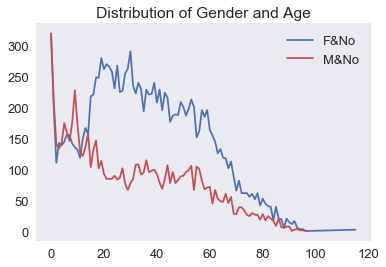

In [27]:
#单独取出'Gender','show','Age'的数据
Gender_Age = df.groupby(['Gender','show','Age'])['PatientId'].count()
Gender_Age.name='count'


#可视化
plt.plot(Gender_Age['F'][0].index,Gender_Age['F'][0].values,'b')
plt.plot(Gender_Age['M'][0].index,Gender_Age['M'][0].values,'r')

plt.legend(['F&No','M&No'])
plt.title("Distribution of Gender and Age")

从性别的角度分析，20岁以上的女性患者预约人数多于男性，爽约情况比男性患者要多。

# Others

In [28]:
#将Handcap划分为0，1两种情况进行分析
df['Handcap'] = df['Handcap'].apply(lambda x: 1 if x != 0 else x)

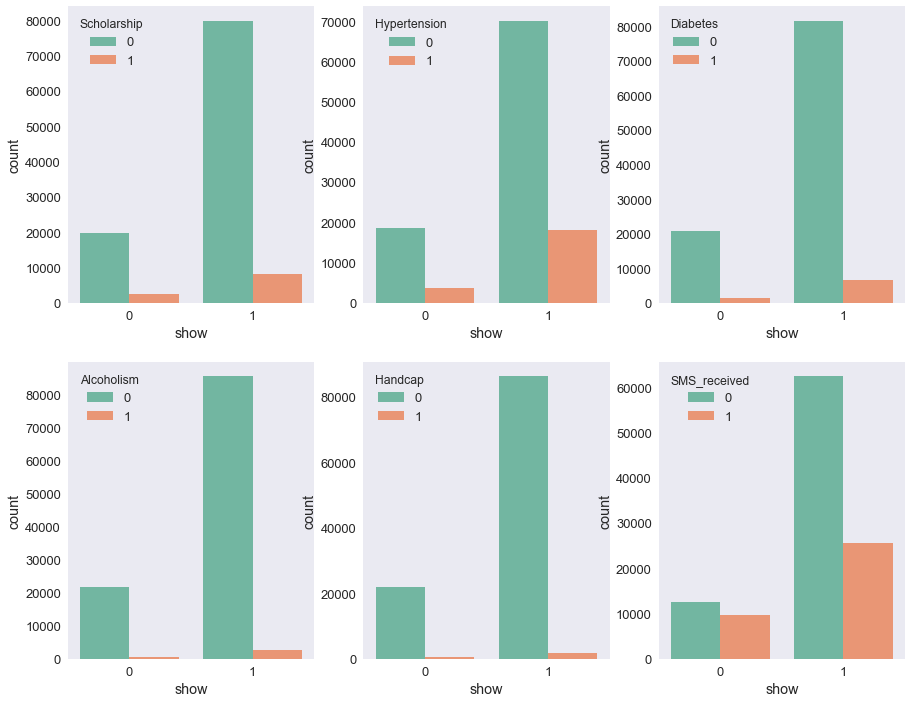

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(15, 12))

sns.countplot(x='show', data=df,hue='Scholarship',ax=ax[0,0],palette='Set2')
sns.countplot(x='show', data=df,hue='Hypertension',ax=ax[0,1],palette='Set2')
sns.countplot(x='show', data=df,hue='Diabetes', ax=ax[0,2], palette='Set2')
sns.countplot(x='show', data=df,hue='Alcoholism', ax=ax[1,0],palette='Set2')
sns.countplot(x='show', data=df,hue='Handcap', ax=ax[1,1],palette='Set2')
sns.countplot(x='show', data=df,hue='SMS_received', ax=ax[1,2],palette='Set2')

In [30]:
df_Scholarship_0 = df.show[df.Scholarship == 0].value_counts()
df_Scholarship_1 = df.show[df.Scholarship == 1].value_counts()
Scholarship_show = df_Scholarship_1[1]/(df_Scholarship_1[1]+df_Scholarship_1[0])
noScholarship_show = df_Scholarship_0[1]/(df_Scholarship_0[1]+df_Scholarship_0[0])
print("The percent of Scholarship who showed up : {}% ".format(float("%.2f" % (Scholarship_show*100))))
print("The percent of noScholarship who showed up : {}% ".format("%.2f" % (noScholarship_show*100)))

The percent of Scholarship who showed up : 76.26% 
The percent of noScholarship who showed up : 80.19% 


In [31]:
df_Hypertension_0 = df.show[df.Hypertension == 0].value_counts()
df_Hypertension_1 = df.show[df.Hypertension == 1].value_counts()
Hypertension_show = df_Hypertension_1[1]/(df_Hypertension_1[1]+df_Hypertension_1[0])
noHypertension_show = df_Hypertension_0[1]/(df_Hypertension_0[1]+df_Hypertension_0[0])
print("The percent of Hypertension who showed up : {}% ".format(float("%.2f" % (Hypertension_show*100))))
print("The percent of noHypertension who showed up : {}% ".format("%.2f" % (noHypertension_show*100)))

The percent of Hypertension who showed up : 82.7% 
The percent of noHypertension who showed up : 79.10% 


In [32]:
df_Diabetes_0 = df.show[df.Diabetes == 0].value_counts()
df_Diabetes_1 = df.show[df.Diabetes == 1].value_counts()
Diabetes_show = df_Diabetes_1[1]/(df_Diabetes_1[1]+df_Diabetes_1[0])
noDiabetes_show = df_Diabetes_0[1]/(df_Diabetes_0[1]+df_Diabetes_0[0])
print("The percent of Diabetes who showed up : {}% ".format(float("%.2f" % (Diabetes_show*100))))
print("The percent of noDiabetes who showed up : {}% ".format("%.2f" % (noDiabetes_show*100)))

The percent of Diabetes who showed up : 82.0% 
The percent of noDiabetes who showed up : 79.64% 


In [33]:
df_Alcoholism_0 = df.show[df.Alcoholism == 0].value_counts()
df_Alcoholism_1 = df.show[df.Diabetes == 1].value_counts()
Alcoholism_show = df_Alcoholism_1[1]/(df_Alcoholism_1[1]+df_Alcoholism_1[0])
noAlcoholism_show = df_Alcoholism_0[1]/(df_Alcoholism_0[1]+df_Alcoholism_0[0])
print("The percent of Alcoholism who showed up : {}% ".format(float("%.2f" % (Alcoholism_show*100))))
print("The percent of noAlcoholism who showed up : {}% ".format("%.2f" % (noAlcoholism_show*100)))

The percent of Alcoholism who showed up : 82.0% 
The percent of noAlcoholism who showed up : 79.81% 


In [35]:
df_Handcap_0 = df.show[df.Handcap == 0].value_counts()
df_Handcap_1 = df.show[df.Handcap == 1].value_counts()
Handcap_show = df_Handcap_1[1]/(df_Handcap_1[1]+df_Handcap_1[0])
noHandcap_show = df_Handcap_0[1]/(df_Handcap_0[1]+df_Handcap_0[0])
print("The percent of Handcap who showed up : {}% ".format(float("%.2f" % (Handcap_show*100))))
print("The percent of noHandcap who showed up : {}% ".format("%.2f" % (noHandcap_show*100)))

The percent of Handcap who showed up : 81.84% 
The percent of noHandcap who showed up : 79.76% 


In [36]:
df_SMS_received_0 = df.show[df.SMS_received == 0].value_counts()
df_SMS_received_1 = df.show[df.SMS_received == 1].value_counts()
SMS_received_show = df_SMS_received_1[1]/(df_SMS_received_1[1]+df_SMS_received_1[0])
noSMS_received_show = df_SMS_received_0[1]/(df_SMS_received_0[1]+df_SMS_received_0[0])
print("The percent of SMS_received who showed up : {}% ".format(float("%.2f" % (SMS_received_show*100))))
print("The percent of noSMS_received who showed up : {}% ".format("%.2f" % (noSMS_received_show*100)))

The percent of SMS_received who showed up : 72.43% 
The percent of noSMS_received who showed up : 83.30% 


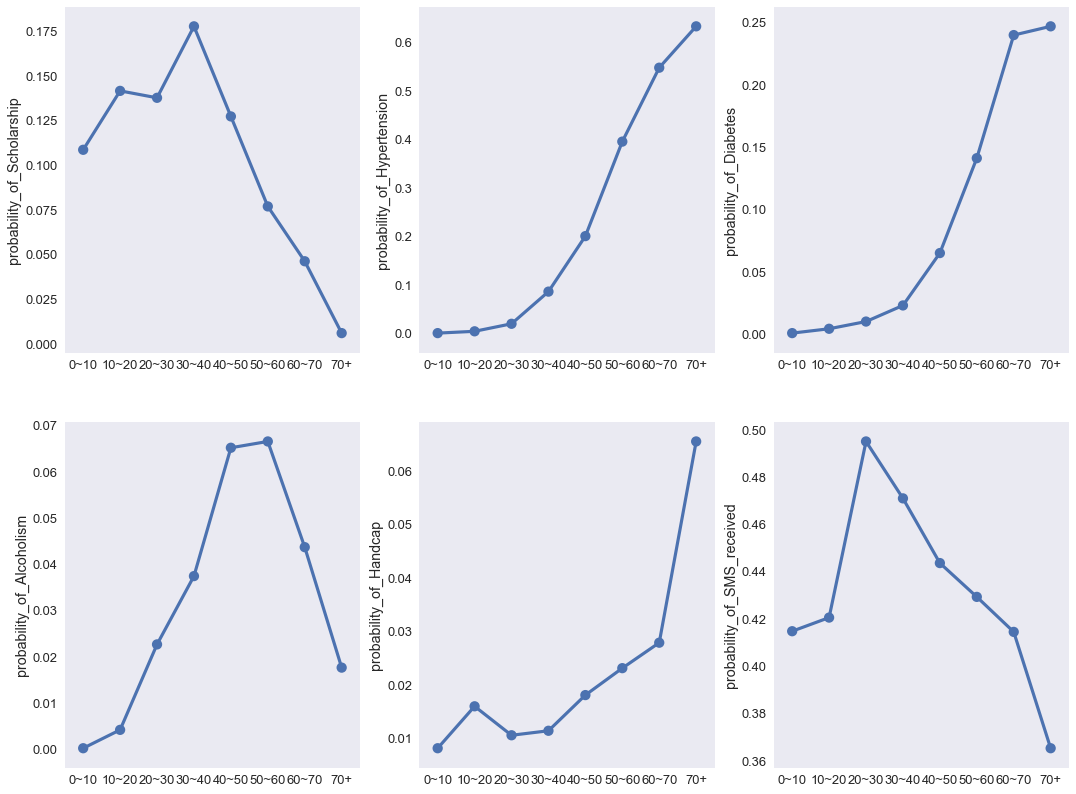

In [37]:
# 在爽约的情况下，分析不同年龄阶段受不同因素影响的情况
df_noshow = df[df['show']==0]
fig, ax = plt.subplots(2, 3, figsize=(18, 14))

probability_of_Scholarship = df_noshow.query('Scholarship == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_Scholarship.name = 'probability_of_Scholarship'

probability_of_Hypertension = df_noshow.query('Hypertension == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_Hypertension.name = 'probability_of_Hypertension'

probability_of_Diabetes = df_noshow.query('Diabetes == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_Diabetes.name = 'probability_of_Diabetes'

probability_of_Alcoholism = df_noshow.query('Alcoholism == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_Alcoholism.name = 'probability_of_Alcoholism'

probability_of_Handcap = df_noshow.query('Handcap == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_Handcap.name = 'probability_of_Handcap'

probability_of_SMS_received = df_noshow.query('SMS_received == 1')['phase'].value_counts(sort=False)/df_noshow['phase'].value_counts(sort=False)
probability_of_SMS_received.name = 'probability_of_SMS_received'


sns.pointplot(x=probability_of_Scholarship.index, y=probability_of_Scholarship, ax=ax[0,0], color='b')
sns.pointplot(x=probability_of_Hypertension.index, y=probability_of_Hypertension, ax=ax[0,1], color='b')
sns.pointplot(x=probability_of_Diabetes.index, y=probability_of_Diabetes, ax=ax[0,2], color='b')
sns.pointplot(x=probability_of_Alcoholism.index, y=probability_of_Alcoholism, ax=ax[1,0], color='b')
sns.pointplot(x=probability_of_Handcap.index, y=probability_of_Handcap, ax=ax[1,1], color='b')
sns.pointplot(x=probability_of_SMS_received.index, y=probability_of_SMS_received, ax=ax[1,2], color='b')

在已经爽约的情况下：

* 年龄在70岁以上患者有心脏病、糖尿病、残疾的人数占该年龄段总人数的比例最高
* 年龄在40-50、50-60岁的患者酗酒人数占该年龄段总人数的比例最高
* 年龄在20-30岁的患者收到短信人数占该年龄段总人数比例最高
* 年龄在30-40岁有医疗保险的人数占该年龄段总人数的比例最高


# Waiting of Days

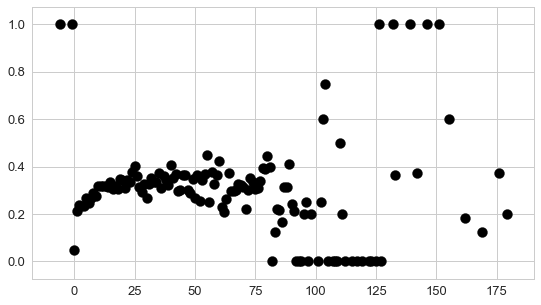

In [38]:
# 不同的等待时间情况下，没有如约就诊人数的比例
from collections import Counter
%matplotlib inline 
sns.set_style('whitegrid')

plt.figure(figsize = (9,5))
for x in df['waiting_day'].unique():
    plt.scatter(x, (Counter(df[df['waiting_day'] == x]['show'])[0]/len(df[df['waiting_day']==x])),c='black',s=100)

从图中可以发现，预约时间超过100天之后的点的分布就比较分散了，其中一个原因是预约这么长时间之后就诊的患者人数不多，所以极少数人的情况会对整体造成比较大的影响。然后在图中还可以看到小于0的数据点，这应该是属于输入错误之类的异常值。

In [39]:
len(df[df['waiting_day']>=100])/len(df)

0.0012485636993675754

In [40]:
Counter(df[df['waiting_day'] <0 ]['show'])

Counter({0: 5})

In [41]:
df[df['waiting_day'] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day,phase
27033,7839272661752,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0,-1,30~40
55226,7896293967868,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,-1,10~20
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-1,20~30
71533,998231581612122,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,-6,70+
72362,3787481966821,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0,-1,0~10


In [42]:
df[df['PatientId']==24252258389979]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day,phase
54692,24252258389979,5657354,F,2016-05-04 09:15:43,2016-05-19,22,CONSOLAÇÃO,0,0,0,0,0,0,0,15,20~30
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-1,20~30


wating_day小于0的情况有5条数据，并且都没有如约就诊，利用PatientId观察打印出来的数据后发现，应该是属于信息录入错误。因为一般等待时间小于0都有过另外一条预约同一时间或临近时间的记录。可以将这些异常值删除。

In [43]:
#删除异常记录
df = df[df['waiting_day'] >= 0]

由于上一副waiting_day时间连续的散点图中没有得到什么结论，尝试将连续时间分段观察看看，创建新变量waitingofdays

In [44]:
time_labels = ['Immediately','OneDay','OneWeek','TwoWeek','OneMonth','OveroneMonth']
time_cut = [-1,0,1,7,14,30,200]
df['waitingofdays'] = pd.cut(df['waiting_day'], time_cut, labels=time_labels)

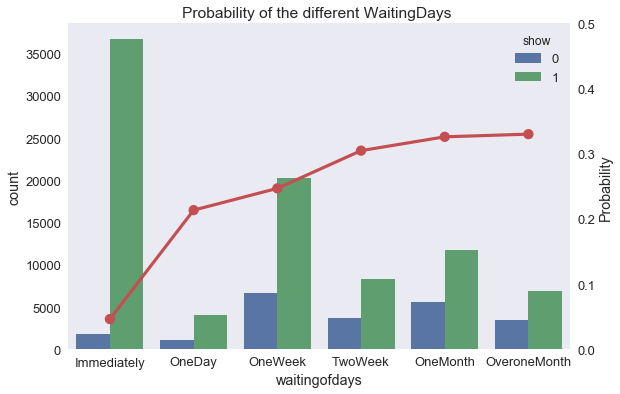

In [45]:
probability = df.query('show == 0')['waitingofdays'].value_counts(sort=False)/df['waitingofdays'].value_counts(sort=False)
probability.name = 'Probability'

#设置背景参数、图片参数
plt.figure(figsize=(9,6))
sns.set(style='dark', color_codes=True, font_scale=1.3)

ax1 = sns.countplot(x='waitingofdays', data=df, hue='show')
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])
sns.pointplot(x=probability.index, y=probability, color='r', ax=ax2)
plt.title('Probability of the different WaitingDays ');

由以上图片可以看出，预约当天就诊的患者人数最多，并且违约率最低，就诊率高达95%。

# 结论

#### 1、对该数据集分析发现，爽约人数占总数的20%左右，其中0～10岁年龄段预约人数最多，爽约情况也最多；
#### 2、没有高血压的患者就诊率为79.1%，有高血压的患者就诊率是82.7%；没有糖尿病的患者就诊率是79.64%，有糖尿病的患者就诊率是82%；
####       没有酗酒的患者就诊率是79.81% ，有酗酒的患者就诊率是82.0% ；没有伤残患者就诊率为79.8%，有伤残患者的就诊率是81.8%；
####       没有接收短信提醒的患者就诊率为72.43%，接收了短信提醒的患者就诊率为83.3%，说明这些因素对于就诊率是有一定的影响的。
#### 3、等待时间对于就诊率也有一定的影响，立即就诊的爽约率最低，然后随着时间增加爽约率呈现上升趋势；
#### 4、年龄在10～30岁患者爽约率最高，随着年龄升高，爽约率呈现下降趋势；
#### 5、在已经爽约的情况下：
####    年龄在70岁以上患者有心脏病、糖尿病、残疾的人数占该年龄段总人数的比例最高；
####    年龄在40-50、50-60岁的患者酗酒人数占该年龄段总人数的比例最高；
####    年龄在20-30岁的患者收到短信人数占该年龄段总人数比例最高；
####    年龄在30-40岁有医疗保险的人数占该年龄段总人数的比例最高。有Scholarship说明是巴西福利项目Bolsa Família 的保障人群，对于每个人月均收入低于贫困线的家庭提供儿童接种疫苗津贴，所以大概是这个年龄段有小孩的家庭福利津贴占比最高是可以理解的。


# Predict 

In [46]:
#将neighbourhood列的值变成数字标签
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Neighbourhood_label'] = le.fit_transform(df['Neighbourhood'])

In [47]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day,phase,waitingofdays,Neighbourhood_label
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,60~70,Immediately,39
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,50~60,Immediately,39
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,60~70,Immediately,45
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,0~10,Immediately,54
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,50~60,Immediately,39


In [48]:
df['Gender'] = df['Gender'].map({'F':0,'M':1})

In [49]:
data = df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay','Neighbourhood','phase','waitingofdays'],axis=1)

In [50]:
data.head()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,show,waiting_day,Neighbourhood_label
0,0,62,0,1,0,0,0,0,1,0,39
1,1,56,0,0,0,0,0,0,1,0,39
2,0,62,0,0,0,0,0,0,1,0,45
3,0,8,0,0,0,0,0,0,1,0,54
4,0,56,0,1,1,0,0,0,1,0,39


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 11 columns):
Gender                 110522 non-null int64
Age                    110522 non-null int64
Scholarship            110522 non-null int64
Hypertension           110522 non-null int64
Diabetes               110522 non-null int64
Alcoholism             110522 non-null int64
Handcap                110522 non-null int64
SMS_received           110522 non-null int64
show                   110522 non-null uint8
waiting_day            110522 non-null int64
Neighbourhood_label    110522 non-null int64
dtypes: int64(10), uint8(1)
memory usage: 14.4 MB


In [52]:
data['show'] = data['show'].astype(int)

In [53]:
X = data.drop(['show'],axis=1)
y = data['show']

In [54]:
X.head()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,waiting_day,Neighbourhood_label
0,0,62,0,1,0,0,0,0,0,39
1,1,56,0,0,0,0,0,0,0,39
2,0,62,0,0,0,0,0,0,0,45
3,0,8,0,0,0,0,0,0,0,54
4,0,56,0,1,1,0,0,0,0,39


In [55]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: show, dtype: int64

In [56]:
Counter(y)

Counter({1: 88208, 0: 22314})

In [57]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=101)
X_res, y_res = sm.fit_sample(X, y)
Counter(y_res)

Counter({1: 88208, 0: 88208})

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=42)

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
clf.feature_importances_

array([0.09277081, 0.20861343, 0.03242051, 0.04100395, 0.01993781,
       0.00754449, 0.00688027, 0.10495494, 0.30701884, 0.17885495])

In [61]:
from sklearn.metrics import accuracy_score

pred = clf.predict(X_test)
print(accuracy_score(pred,y_test))

0.8503763830945039
